## Summary

----

## Imports

In [1]:
import os
import shutil
import subprocess
from collections import Counter
from pathlib import Path

import logomaker
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import proteinsolver
import pyarrow as pa
import pyarrow.parquet as pq
from IPython.display import set_matplotlib_formats
from kmbio import PDB

In [2]:
pd.set_option("max_columns", 1000)
pd.set_option("max_rows", 1000)

In [3]:
set_matplotlib_formats("svg")

## Parameters

In [4]:
NOTEBOOK_DIR = Path("11_profile_recovery").resolve()
NOTEBOOK_DIR.mkdir(exist_ok =True)

NOTEBOOK_DIR

PosixPath('/home/kimlab1/strokach/workspace/proteinsolver/notebooks/11_profile_recovery')

In [5]:
UNIQUE_ID = "191f05de"

In [6]:
DESIGNS_PATH = NOTEBOOK_DIR.parent.joinpath("generate_protein_sequences")
assert DESIGNS_PATH.is_dir()

DESIGNS_PATH

PosixPath('/home/kimlab1/strokach/workspace/proteinsolver/notebooks/generate_protein_sequences')

In [7]:
# 1n5uA03 4z8jA00 4unuA00 4beuA02
STRUCTURE_ID = "4beuA02"

# 100 95 60 35
RL = 35

## Download data

In [8]:
for seq_identity in [100, 95, 60, 35]:
    print(seq_identity)
    if not NOTEBOOK_DIR.joinpath(f"cath-domain-seqs-S{seq_identity}.fa").is_file():
        !(cd {NOTEBOOK_DIR} && wget -nv -c ftp://orengoftp.biochem.ucl.ac.uk/cath/releases/latest-release/sequence-data/cath-domain-seqs-S{seq_identity}.fa)
    if not NOTEBOOK_DIR.joinpath(f"cath-domain-list-S{seq_identity}.txt").is_file():
        !(cd {NOTEBOOK_DIR} && wget -nv -c ftp://orengoftp.biochem.ucl.ac.uk/cath/releases/latest-release/cath-classification-data/cath-domain-list-S{seq_identity}.txt)

100
95
60
35


## Load reference structure

In [9]:
STRUCTURE_FILE = Path(proteinsolver.__path__[0]).joinpath("data", "inputs", f"{STRUCTURE_ID}.pdb")
assert STRUCTURE_FILE.is_file()

STRUCTURE_FILE

PosixPath('/home/kimlab1/strokach/workspace/proteinsolver/proteinsolver/data/inputs/4beuA02.pdb')

In [10]:
structure = PDB.load(STRUCTURE_FILE)

In [11]:
structure_df = structure.to_dataframe()

## Load CATH data

In [12]:
!head {NOTEBOOK_DIR}/cath-domain-seqs-S{RL}.fa

>cath|4_2_0|139lA00/1-162
MNIFEMLRIDEGLRLKIYKDTEGYYTIGIGHLLTKSPSLNAAKSELDKAIGRNTNGVITKDEAEKLFCQDVDAAVRGILRNAKLKPVYDSLDCVRRAALINMVFQMGETGVAGFTNSLRMLQQKRWDEAAVNLAKSRWYNQTPNRAKRVITTFRTGTWDAYKNL
>cath|4_2_0|16pkA01/5-192
EKKSINECDLKGKKVLIRVDFNVPVKNGKITNDYRIRSALPTLKKVLTEGGSCVLMSHLGRPKGIPMAQAGKIRSTGGVPGFQQKATLKPVAKRLSELLLRPVTFAPDCLNAADVVSKMSPGDVVLLENVRFYKEEGSKKAKDREAMAKILASYGDVYISDAFGTAHRDSATMTGIPKILGNGAAGYL
>cath|4_2_0|16vpA00/47-402
SRMPSPPMPVPPAALFNRLLDDLGFSAGPALCTMLDTWNEDLFSALPTNADLYRECKFLSTLPSDVVEWGDAYVPERTQIDIRAHGDVAFPTLPATRDGLGLYYEALSRFFHAELRAREESYRTVLANFCSALYRYLRASVRQLHRQAHMRGRDRDLGEMLRATIADRYYRETARLARVLFLHLYLFLTREILWAAYAEQMMRPDLFDCLCCDLESWRQLAGLFQPFMFVNGALTVRGVPIEARRLRELNHIREHLNLPLVRSAATEEPGAPLTTPPTLHGNQARASGYFMVLIRAKLDSYSSAAPRLSFLPAGHTRRLST
>cath|4_2_0|1914A00/2001-4081
MVLLESEQFLTELTRLFQKCRSSGSVFITLKKYDGRTKPIPRKSSVEGLEPAENKCLLRATDGKRKISTVVSSKEVNKFQMAYSNLLRANMDGLKKRDKKNKSKKSKPAQGGEQKLISEEDDSAGSPMPQFQTWEEFSRAAEKLYLADPMKVRVVLKYRHVDGNLCIKVTDDLVCLVYRTDQAQDVKKIEKFHSQLMRLMVAKESRNVTMETE
>

In [13]:
!head {NOTEBOOK_DIR}/cath-domain-list-S{RL}.txt

1oaiA00     1    10     8    10     1     1     1     1     1    59 1.000
3frhA01     1    10     8    10     2     1     1     1     1    58 1.200
4g3oA00     1    10     8    10     3     1     1     1     1    53 1.600
4heoA00     1    10     8    10     4     1     1     1     1    53 1.650
4wp2F00     1    10     8    10     5     1     1     1     1    55 1.700
1oksA00     1    10     8    10     6     1     1     1     1    51 1.800
4f2lA00     1    10     8    10     7     1     1     1     1    59 1.500
1zv1A00     1    10     8    10     8     1     1     1     1    59 1.600
2qhoD00     1    10     8    10     9     1     1     1     1    49 1.850
4un2B00     1    10     8    10    10     1     1     1     1    43 1.510


In [14]:
columns = [
    "domain_name",
    "Class number",
    "Architecture number",
    "Topology number",
    "Homologous superfamily number",
    "S35 sequence cluster number",
    "S60 sequence cluster number",
    "S95 sequence cluster number",
    "S100 sequence cluster number",
    "S100 sequence count number",
    "Domain length",
    "Structure resolution (A)",
]

cath_domain_df = pd.read_csv(NOTEBOOK_DIR / f"cath-domain-list-S{RL}.txt", sep=" +", engine="python", names=columns)

cath_domain_df["domain_superfamily"] = (
    cath_domain_df["Class number"].astype(str)
    + "."
    + cath_domain_df["Architecture number"].astype(str)
    + "."
    + cath_domain_df["Topology number"].astype(str)
    + "."
    + cath_domain_df["Homologous superfamily number"].astype(str)
)

cath_domain_df.head()

,domain_name,Class number,Architecture number,Topology number,Homologous superfamily number,S35 sequence cluster number,S60 sequence cluster number,S95 sequence cluster number,S100 sequence cluster number,S100 sequence count number,Domain length,Structure resolution (A),domain_superfamily
0,1oaiA00,1,10,8,10,1,1,1,1,1,59,1.00,1.10.8.10
1,3frhA01,1,10,8,10,2,1,1,1,1,58,1.20,1.10.8.10
2,4g3oA00,1,10,8,10,3,1,1,1,1,53,1.60,1.10.8.10
3,4heoA00,1,10,8,10,4,1,1,1,1,53,1.65,1.10.8.10
4,4wp2F00,1,10,8,10,5,1,1,1,1,55,1.70,1.10.8.10


In [15]:
structure_id_to_superfamily = {
    "1n5uA03": "1.10.246.10",
    "4z8jA00": "2.30.42.10",
    "4unuA00": "2.60.40.10",
    "4beuA02": "3.20.20.10",
}

ref_superfamily = structure_id_to_superfamily[STRUCTURE_ID]

ref_superfamily

'3.20.20.10'

In [16]:
domains_to_keep = set(cath_domain_df[cath_domain_df["domain_superfamily"] == ref_superfamily]["domain_name"])

len(domains_to_keep)

32

In [17]:
def read_cath_domain_seqs(file, domains_to_keep):
    results = []
    row = None
    with file.open("rt") as fin:
        for line in fin:
            if line.startswith(">"):
                if row is not None:
                    results.append(row)
                    row = None
                cath, cath_version, domain = line.strip().strip(">").split("|")
                domain_name, domain_range = domain.split("/")
                if domain_name in domains_to_keep:
                    row = {"domain_name": domain_name, "domain_range": domain_range, "sequence": ""}
            elif row is not None:
                row["sequence"] += line.strip()
    if row is not None:
        results.append(row)
    return results

In [18]:
def resname_to_aa(resname, if_unknown="error"):
    from kmtools.structure_tools.constants import AAA_DICT, RESIDUE_MAPPING_TO_CANONICAL

    if resname in AAA_DICT:
        residue_aa = AAA_DICT[resname]
    elif resname in RESIDUE_MAPPING_TO_CANONICAL:
        residue_aa = AAA_DICT[RESIDUE_MAPPING_TO_CANONICAL[resname]]
    elif if_unknown == "replace":
        residue_aa = unknown_residue_marker
    else:
        raise Exception

    return residue_aa

In [19]:
results = read_cath_domain_seqs(NOTEBOOK_DIR / f"cath-domain-seqs-S{RL}.fa", domains_to_keep)

assert len(results) == len(domains_to_keep)

In [20]:
row_ref = {
    "domain_name": f"{STRUCTURE_ID}-ref",
    "domain_range": f"1-{structure_df['residue_idx'].max()}",
    "sequence": "".join(
        structure_df.drop_duplicates("residue_idx")["residue_resname"].apply(resname_to_aa)
    ),
}

results_df = pd.DataFrame([row_ref] + results)

assert STRUCTURE_ID in results_df["domain_name"].values

results_df = results_df[results_df["domain_name"] != STRUCTURE_ID].copy()

In [21]:
results_df.head()

,domain_name,domain_range,sequence
0,4beuA02-ref,1-216,LGQFQSNIEQFKSHMNANTKICAIMKADAYGNGIRGLMPTIIAQGI...
1,1bd0A01,14-224,LDAIYDNVENLRRLLPDDTHIMAVVKANAYGHGDVQVARTALEAGA...
2,1ct5A00,3-246,STGITYDEDRKTQLIAQYESVREVVNAEAKNVHVNENASKILLLVV...
3,1knwA02,33-277,AQIIRRQIAALKQFDVVRFAQKACSNIHILRLMREQGVKVDSVSLG...
4,1rcqA02,10-216,LQALRHNYRLAREATGARALAVIKADAYGHGAVRCAEALAAEADGF...


In [22]:
len(results_df)

32

## Workspace

### Run muscle

In [23]:
input_text = "\n".join(f">{row.Index}\n{row.sequence}" for row in results_df.itertuples())

In [24]:
cp = subprocess.run(
    ["clustalo", "--in", "-"],
    input=input_text,
    stdout=subprocess.PIPE,
    stderr=subprocess.PIPE,
    universal_newlines=True,
    check=True,
)

In [25]:
def parse_muscle_output(stdout):
    results = []
    row = None
    for line in stdout.split():
        if line.startswith(">"):
            if row is not None:
                results.append(row)
                row = None
            row = {"Index": int(line.strip().strip(">")), "aligned_sequence": ""}
        else:
            row["aligned_sequence"] += line.strip()
    if row is not None:
        results.append(row)
    return results

In [26]:
muscle_results = parse_muscle_output(cp.stdout)

In [27]:
muscle_results_df = pd.DataFrame(muscle_results).set_index("Index")

In [28]:
assert len(muscle_results_df) == len(results_df)
muscle_results_df.head()

,aligned_sequence
Index,
0,---------------------LGQFQSNIEQFKSHMNAN-------...
1,---------------------LDAIYDNVENLRRLLPDD-------...
2,-----------STGITYDEDRKTQLIAQYESVREVVNAEAKNVHVN...
3,---------------------AQIIRRQIAAL-KQF----------...
4,---------------------LQALRHNY-RLAREAT-G-------...


### Add alignment results back to reference

In [29]:
results_df.tail()

,domain_name,domain_range,sequence
28,4qhrA02,10-217,RQALQYNLNRVKQLAANSKIVSMVXANAYGHGVKDCLAALNASDAF...
29,4v15A02,33-255,LPAFEANLRAMQAWADRHEVALRPHAKAHKCPEIALRQLALGARGI...
30,5fagA02,22-242,LAALRANVRALRERAPGAALMAVVKADAYGHGAIPCARAAVAAGAT...
31,5gjnA02,28-262,DKVEENYQFMRRHLPRAGVFYAMKANPTPEILSLLAGLGSHFDVAS...
32,7odcA02,48-279,ILKKHLRWLKALPRVTPFYAVKCNDSRAIVSTLAAIGTGFDCASKT...


In [30]:
if "aligned_sequence" not in results_df:
    results_df["aligned_sequence"] = muscle_results_df["aligned_sequence"]

assert results_df["aligned_sequence"].notnull().all()
assert (results_df["aligned_sequence"].str.replace("-", "") == results_df["sequence"]).all()

### Generate sequence matrix

In [31]:
sequence_mat = np.array([v for v in results_df["aligned_sequence"].str.split("").str[1:-1]])

assert sequence_mat.shape[0] == len(results_df)
assert sequence_mat.shape[1] == len(results_df.iloc[0]["aligned_sequence"])

# Remove first reference sequence
assert results_df.index[0] == 0
sequence_mat = sequence_mat[1:, sequence_mat[0, :] != "-"]

assert sequence_mat.shape[1] == len(results_df.iloc[0]["sequence"])

### Generate residue probability tables

In [32]:
columns = list("GVALICMFWPDESTYQNKRH")
assert len(columns) == 20
assert len(set(columns)) == 20

results = []
for aa_in_pos in sequence_mat.T:
    counts = Counter(aa_in_pos)
    row = [counts[aa] for aa in columns]
    results.append(row)

aa_counts = pd.DataFrame(results, columns=columns)


# Handle errors in case all values except for reference are gaps
with np.errstate(divide="ignore", invalid="ignore"):
    aa_proba = pd.DataFrame(
        aa_counts.values / aa_counts.values.sum(axis=1).reshape(-1, 1), columns=columns
    )
aa_proba.index.name = "pos"
pq.write_table(
    pa.Table.from_pandas(aa_proba, preserve_index=False),
    NOTEBOOK_DIR.joinpath(f"{STRUCTURE_ID}-rl{RL}-aa-proba.parquet"),
)


aa_proba_adj = pd.DataFrame(
    (aa_counts.values + 1) / (aa_counts.values + 1).sum(axis=1).reshape(-1, 1), columns=columns
)
aa_proba_adj.index.name = "pos"
assert np.allclose(aa_proba_adj.sum(axis=1).values, 1)
pq.write_table(
    pa.Table.from_pandas(aa_proba_adj, preserve_index=False),
    NOTEBOOK_DIR.joinpath(f"{STRUCTURE_ID}-rl{RL}-aa-proba-adj.parquet"),
)


max_bits = -np.log2(1 / 20)
max_bits_per_pos = max_bits - (-aa_proba_adj.values * np.log2(aa_proba_adj.values)).sum(axis=1)
aa_bits = pd.DataFrame(aa_proba_adj.values * max_bits_per_pos.reshape(-1, 1), columns=columns)
pq.write_table(
    pa.Table.from_pandas(aa_bits, preserve_index=False),
    NOTEBOOK_DIR.joinpath(f"{STRUCTURE_ID}-rl{RL}-aa-bits.parquet"),
)

In [33]:
aa_bits.head()

,G,V,A,L,I,C,M,F,W,P,D,E,S,T,Y,Q,N,K,R,H
0,0.019350,0.029025,0.029025,0.096752,0.009675,0.029025,0.019350,0.009675,0.009675,0.009675,0.009675,0.038701,0.009675,0.009675,0.009675,0.009675,0.009675,0.029025,0.038701,0.009675
1,0.019243,0.009622,0.028865,0.009622,0.009622,0.009622,0.009622,0.009622,0.009622,0.019243,0.115460,0.028865,0.019243,0.028865,0.009622,0.038487,0.028865,0.019243,0.028865,0.009622
2,0.013663,0.013663,0.068314,0.006831,0.020494,0.006831,0.006831,0.013663,0.006831,0.006831,0.020494,0.020494,0.013663,0.027326,0.006831,0.013663,0.020494,0.020494,0.020494,0.006831
3,0.014550,0.072751,0.043651,0.160053,0.160053,0.014550,0.029100,0.058201,0.014550,0.014550,0.014550,0.014550,0.014550,0.014550,0.014550,0.014550,0.014550,0.014550,0.014550,0.014550
4,0.011973,0.023945,0.047890,0.023945,0.023945,0.011973,0.011973,0.011973,0.011973,0.011973,0.011973,0.119726,0.011973,0.023945,0.023945,0.035918,0.023945,0.011973,0.131699,0.011973


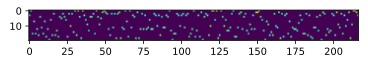

In [34]:
sequence_ref = results_df["sequence"].values[0]
mat = np.zeros((len(sequence_ref), len(columns)), dtype=np.float)
mat[np.arange(len(sequence_ref)), np.array([columns.index(aa) for aa in sequence_ref])] = 1.0
plt.imshow(mat.T)
sequence_ref_df = pd.DataFrame(mat, columns=columns)

In [35]:
chunk_size = 55
num_chunks = len(aa_bits) // chunk_size + 1
height_ratios = [1, 8, 3] * num_chunks
height_ratios[-1] = 1.5

fg, axs = plt.subplots(
    num_chunks * 3,
    1,
    figsize=(12, 2 * num_chunks),
    gridspec_kw={
        "height_ratios": height_ratios,
        "hspace": 0,
        "left": 0.045,
        "right": 1,
        "top": 1,
        "bottom": 0,
    },
)
for i, start in enumerate(range(0, len(aa_bits), chunk_size)):
    ax = axs[i * 3]
    df_chunk = sequence_ref_df.iloc[start : start + chunk_size]
    _ = logomaker.Logo(df_chunk, ax=ax)
    ax.set_xlim(start - 0.475, start + chunk_size - 0.525)
    ax.axis("off")

    ax = axs[i * 3 + 1]
    df_chunk = aa_bits.iloc[start : start + chunk_size]
    _ = logomaker.Logo(df_chunk, ax=ax)
    ax.set_xlim(start - 0.475, start + chunk_size - 0.525)
    #     ax.set_ylim(0, max_bits)
    ax.set_ylim(0, aa_bits.sum(axis=1).values.max() * 1.1)
    ax.set_ylabel("bits")

    ax = axs[i * 3 + 2]
    ax.axis("off")
fg.savefig(NOTEBOOK_DIR.joinpath(f"{STRUCTURE_ID}-rl{RL}-profile-logo.svg"))
fg.savefig(NOTEBOOK_DIR.joinpath(f"{STRUCTURE_ID}-rl{RL}-profile-logo.pdf"))
fg.savefig(NOTEBOOK_DIR.joinpath(f"{STRUCTURE_ID}-rl{RL}-profile-logo.png"), dpi=300)